In [77]:
# note: fdfdpy_OO must be in your JUPYTER_PATH for this import to work (or you can manually add it to path with some google=able code.)
from fdfdpy.Fdfd import Fdfd

import numpy as np
import matplotlib.pylab as plt
import scipy.sparse as sp

%load_ext autoreload
%autoreload 2
%matplotlib inline

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [78]:
omega = 5e14                # angular frequency (2pi)
dl = 0.04                   # grid size L0
eps_r = np.ones((100,100))  # relative permittivity
eps_r[40:60, 40:60] = 5     # define box
NPML = [10, 10]             # number of pml grid points on x and y borders
pol = 'Ez'                  # polarization (either 'Hz' or 'Ez')

In [79]:
# sets simulation variables, constructs system matrix 'A', stored in 'simulation' object
simulation = Fdfd(omega,eps_r,dl,NPML,pol)

In [80]:
# set source and solve for electromagnetic fields
b = np.zeros((simulation.Nx,simulation.Ny))
b[40:60,30] = 100
(Hx,Hy,Ez) = simulation.solve_fields(b)

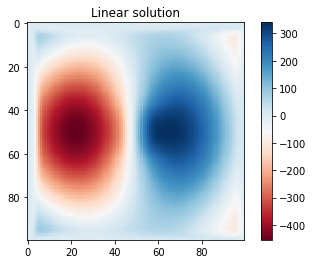

In [81]:
# plot
plt.imshow(np.real(Ez), cmap='RdBu')
plt.colorbar()
plt.title('Linear solution')
plt.show()

In [132]:
chi3 = 2.8*1e-18         # Silcion in m^2/V^2 from Boyd's book
chi3_fdfd = chi3/simulation.L0**2        # In the units of the FDFD solver such that eps_nl = eps_r + 3*chi3_fdfd*|e|^2
nl_region = np.zeros(eps_r.shape)  # Nonliearity region
nl_region[40:60, 40:60] = 1
# Define nonlinear function
kerr_nonlinearity = lambda e: 3*chi3_fdfd*np.square(np.abs(e))
# Define the partial derivative of the nonlinear function w.r.t. e
kerr_nl_de = lambda e: 3*chi3_fdfd*np.conj(e)

the simulation did not converge, reached 0.00029153937499721953


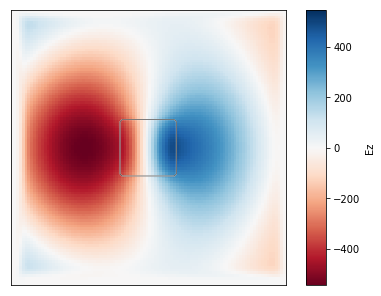

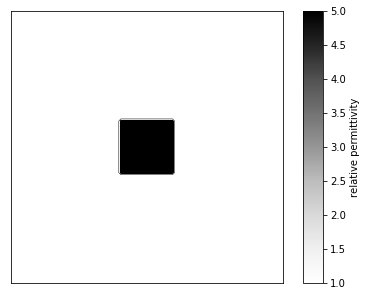

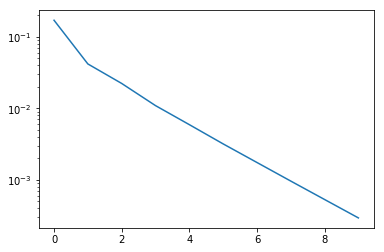

In [83]:
# Do a born solve for the nonlinear fields
# solve the nonlinear fields.
simulation_nl = Fdfd(omega, eps_r, dl, NPML, pol)
(Hx_nl, Hy_nl, Ez_nl_B, convergence) = simulation_nl.solve_fields_nl(b, kerr_nonlinearity, nl_region,
                                          dnl_de=kerr_nl_de, timing=False, averaging=False,
                                          Estart=None, solver_nl='born', max_num_iter=10)

# plot results
simulation_nl.plt_re()
simulation_nl.plt_eps()
plt.show()
plt.plot(convergence)
plt.yscale('log')

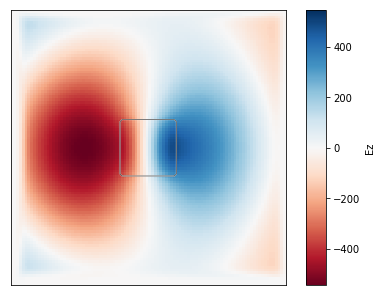

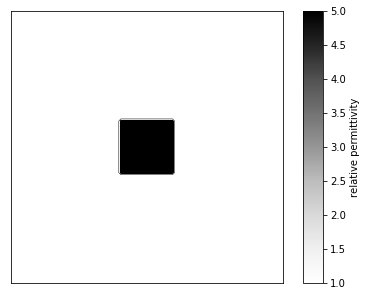

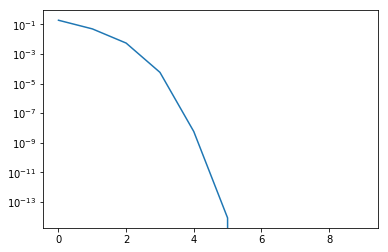

In [85]:
# Do a newton solve for the nonlinear fields
simulation_nl = Fdfd(omega, eps_r, dl, NPML, pol)
(Hx_nl, Hy_nl, Ez_nl_N, convergence) = simulation_nl.solve_fields_nl(b, kerr_nonlinearity, nl_region,
                                          dnl_de=kerr_nl_de, timing=False, averaging=False,
                                          Estart=None, solver_nl='newton', max_num_iter=10)

# plot results
simulation_nl.plt_re()
simulation_nl.plt_eps()
plt.show()
plt.plot(convergence)
plt.yscale('log')

In [69]:
print(np.linalg.norm(Ez_nl_B - Ez_nl_N))

9.551835568564556


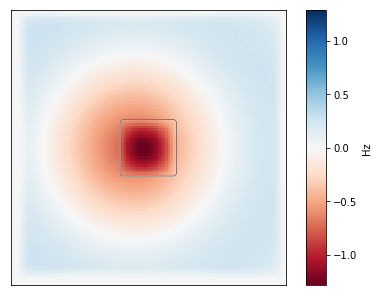

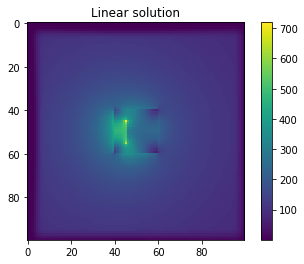

In [133]:
# Now try Hz
pol = 'Hz'              
simulation = Fdfd(omega,eps_r,dl,NPML,pol)
# set source and solve for electromagnetic fields
b = np.zeros((simulation.Nx,simulation.Ny))
# Taking source power such that the E-field intensity is comparable to the Ez-case above
# Also putting it in the material because otherwise the E-field is pretty small
b[45:55,45] = 20000     
(Ex,Ey,Hz) = simulation.solve_fields(b)
# plot results
simulation.plt_re()
plt.show()
plt.imshow(np.sqrt(np.square(np.abs(Ex)) + np.square(np.abs(Ey))))
plt.colorbar()
plt.title('Linear solution')
plt.show()

True
the simulation did not converge, reached 1.0541058174495481e-08


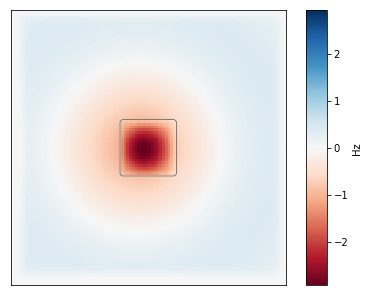

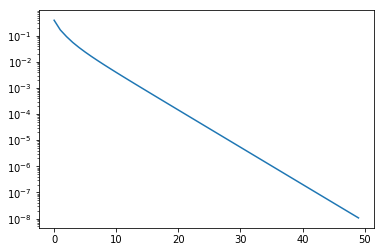

In [135]:
# Do a born solve for the nonlinear fields
# solve the nonlinear fields.
simulation_nl = Fdfd(omega, eps_r, dl, NPML, pol)
(Ex_nl_B, Ey_nl_B, Hz_nl_B, convergence) = simulation_nl.solve_fields_nl(b, kerr_nonlinearity, nl_region,
                                          dnl_de=kerr_nl_de, timing=False, averaging=True,
                                          Estart=None, solver_nl='born', max_num_iter=50)

# plot results
simulation_nl.plt_re()
plt.show()
plt.plot(convergence)
plt.yscale('log')

In [143]:
# Do a newton solve for the nonlinear fields
# solve the nonlinear fields.
simulation_nl = Fdfd(omega, eps_r, dl, NPML, pol)
(Ex_nl_N, Ey_nl_N, Hz_nl_N, convergence) = simulation_nl.solve_fields_nl(b, kerr_nonlinearity, nl_region,
                                          dnl_de=kerr_nl_de, timing=False, averaging=True,
                                          Estart=None, solver_nl='newton', max_num_iter=50)

# plot results
simulation_nl.plt_re()
plt.show()
plt.plot(convergence)
plt.yscale('log')

0
1


RuntimeError: Pardiso - Number of perturbed pivot elements = 256. This could mean that the matrix is singular.

In [144]:
from fdfdpy.nonlinear_solvers import nl_eq_and_jac
from fdfdpy.constants import *
(fE, Jac11, Jac12) = nl_eq_and_jac(simulation, b, simulation.eps_r, nl_region, kerr_nonlinearity, kerr_nl_de, averaging=False,
Ex=Ex, Ey=Ey, Ez=None, matrix_format=DEFAULT_MATRIX_FORMAT)

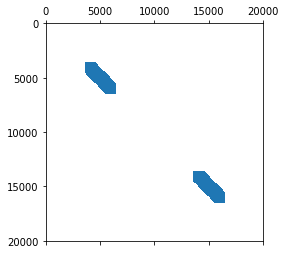

In [145]:
plt.spy(Jac12)
plt.show()

In [146]:
print(fE)

[[ 6.82878993e+10-4.11348129e+10j]
 [ 1.87388947e+11-1.55936793e+10j]
 [ 5.53853607e+11-3.32419448e+10j]
 ...
 [-9.05038180e+13+4.99137695e+13j]
 [-3.18237530e+13+4.04305945e+13j]
 [-4.58294756e+12+1.39793659e+13j]]
